<a href="https://colab.research.google.com/github/GrzegorzPiedel/DataScience-portfolio/blob/main/Fashion%20MNIST%20Image%20Classification%20with%20CNN%20and%20Hyperparameter%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf

keras.utils.set_random_seed(43)
tf.config.experimental.enable_op_determinism()

from sklearn.model_selection import train_test_split

"""
fashion_mnist to zbiór 70 000 obrazków ubrań, każdy 28x28 pikseli, w odcieniach szarości.
Obrazki są już podzielone na:
    X_train, y_train – 60 000 obrazków treningowych
    X_test, y_test – 10 000 obrazków testowych
Każdy X to obrazek, a y to jego etykieta (np. 0 = T-shirt, 1 = spodnie itd.)
"""

fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

"""
X / 255.0 – Skalowanie pikseli do zakresu 0–1
W oryginalnym zbiorze fashion_mnist:
    - każdy obrazek to macierz 28×28 pikseli,
    - wartości pikseli są liczbami od 0 do 255 (bo to szarość).

Dlaczego dzielimy przez 255?
✔️ Bo sieci neuronowe lepiej uczą się, gdy dane wejściowe są małe (np. w zakresie 0–1)
    → Dzięki temu uczenie jest stabilniejsze i szybsze.
"""

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test.shape

"""
X_train.reshape(-1, 28, 28, 1)
oznacza:
    -1 → Python sam policzy liczbę obrazków (np. 48 000)
    28, 28 → rozmiar obrazka
    1 → liczba kanałów (szarość = 1 kanał)

📦 W praktyce to zmienia np. z:
    (48000, 28, 28) ➜ (48000, 28, 28, 1)
"""

'\nX_train.reshape(-1, 28, 28, 1)\noznacza:\n    -1 → Python sam policzy liczbę obrazków (np. 48 000)\n    28, 28 → rozmiar obrazka\n    1 → liczba kanałów (szarość = 1 kanał)\n\n📦 W praktyce to zmienia np. z:\n    (48000, 28, 28) ➜ (48000, 28, 28, 1)\n'

In [ ]:
from tensorflow.keras import layers, models

# Funkcja do tworzenia modelu z tuningiem hiperparametrów
def build_model(hp):
    model = keras.Sequential()  # Tworzymy model sekwencyjny, warstwy są dodawane jedna po drugiej

    # Pierwsza warstwa konwolucyjna
    model.add(
        layers.Conv2D(
            filters = hp.Choice("conv_1_filter", values = [32, 64, 128]),  # Liczba filtrów – jak wiele cech sieć ma wykrywać
            kernel_size = hp.Choice("conv_1_kernel", values = [3, 5]),  # Rozmiar jądra – większe jądro może wychwytywać większe cechy
            activation="leaky_relu",  # Funkcja aktywacji, która pomaga w utrzymaniu aktywności neuronów (nie "umierają")
            input_shape=(28, 28, 1)  # Kształt wejścia (28x28 pikseli, 1 kanał - szarość)
        )
    )

    model.add(layers.MaxPooling2D(2, 2))  # Warstwa MaxPooling – zmniejsza rozmiar obrazu, zachowując najważniejsze cechy

    # Druga warstwa konwolucyjna
    model.add(
        layers.Conv2D(
            filters = hp.Choice("conv_2_filter", values = [32, 64]),
            kernel_size = hp.Choice("conv_2_kernel", values = [3, 5]),
            activation="leaky_relu"
        )
    )

    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())  # Spłaszczamy dane, żeby mogły przejść do warstw gęstych (z 2D na 1D)

    # Warstwa gęsta (fully connected) – tutaj model podejmuje decyzje na podstawie wykrytych cech. Każdy neuron w tej warstwie jest połączony ze wszystkimi neuronami w poprzedniej warstwie.
    model.add(layers.Dense(
        units = hp.Int("dense_units", min_value=32, max_value=128, step=32),  # Liczba jednostek w warstwie – ilość "neuronów"
        activation = "leaky_relu"  # Funkcja aktywacji
    ))

    # Warstwa Dropout – Pomaga to zapobiegać przeuczeniu modelu, zmuszając sieć do uczenia się bardziej niezawodnych cech
    model.add(layers.Dropout(hp.Float("drop", min_value=0.2, max_value=0.5, step=0.1)))

    # Warstwa wyjściowa – 10 jednostek, bo mamy 10 klas, a Softmax daje prawdopodobieństwa dla każdej klasy.
    model.add(layers.Dense(10, activation="softmax")) #Funkcja aktywacji "softmax" jest używana w warstwie wyjściowej dla problemów klasyfikacji wieloklasowej. Konwertuje ona wyjścia neuronów na rozkład prawdopodobieństwa, gdzie suma wszystkich prawdopodobieństw wynosi 1. Najwyższe prawdopodobieństwo wskazuje przewidywaną klasę.

    # Kompilacja modelu – wybór optymalizatora, funkcji straty i metryki
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")  # Dobieranie learning rate – jak szybko model ma się uczyć
        ),
        loss = "sparse_categorical_crossentropy",  # Funkcja straty – porównuje przewidywania modelu z rzeczywistymi etykietami. sparse_categorical_crossentropy jest odpowiednia dla problemów klasyfikacji wieloklasowej, gdy etykiety są podane jako liczby całkowite (a nie jako wektory one-hot)
        metrics = ["accuracy"]  # Metryka dokładności – jak dobrze model przewiduje klasy
    )

    return model

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,                        # funkcja budująca model
    objective='val_accuracy',           # val_accuracy odnosi się do dokładności na     zbiorze walidacyjnym.
    max_trials=3,                       # przetestuj 3 różne wersje
    executions_per_trial=1,             # każdą wersję testuj tylko raz
    directory="tuner_dir",              # katalog na wyniki
    project_name="fashion_cnn"          # nazwa projektu
)

tuner.search(X_train, y_train, epochs = 3, validation_data = (X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_acc = best_model.evaluate(X_test, y_test)

Trial 3 Complete [00h 03m 46s]
val_accuracy: 0.8667500019073486

Best val_accuracy So Far: 0.8824166655540466
Total elapsed time: 00h 15m 10s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8749 - loss: 0.3523


In [ ]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

predictions = best_model.predict(X_test)
y_pred = best_model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


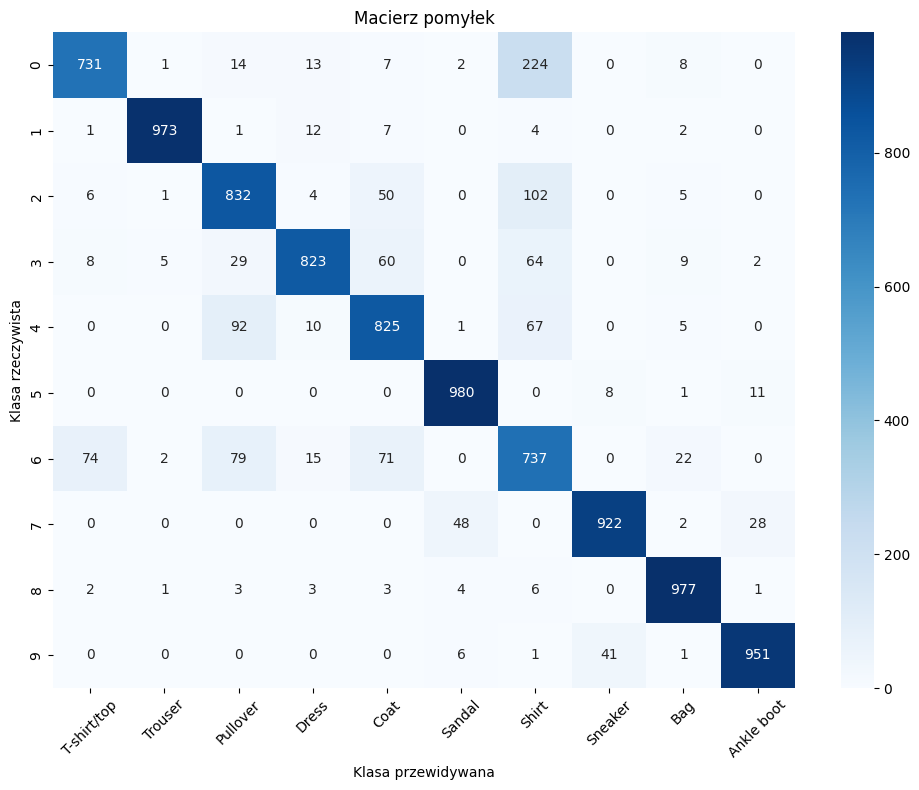

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_classes = y_pred.argmax(axis=1)

"""
Ponieważ Twoja warstwa wyjściowa modelu używa funkcji aktywacji softmax, best_model.predict(X_test) zwraca dla każdego obrazka ze zbioru testowego wektor 10 liczb. Każda z tych liczb reprezentuje prawdopodobieństwo, że dany obrazek należy do jednej z 10 klas (T-shirt/top, Trouser, Pullover, itd.). Suma tych 10 prawdopodobieństw dla każdego obrazka wynosi 1.

Przykład: Dla jednego obrazka, y_pred może wyglądać tak: [0.01, 0.00, 0.85, 0.02, 0.05, 0.00, 0.03, 0.01, 0.02, 0.01]

Tutaj:

0.01 to prawdopodobieństwo, że obrazek to T-shirt/top (klasa 0)
0.00 to prawdopodobieństwo, że obrazek to Trouser (klasa 1)
0.85 to prawdopodobieństwo, że obrazek to Pullover (klasa 2)
...i tak dalej.
Co robi argmax(axis=1)?

argmax() to funkcja, która zwraca indeks największej wartości w tablicy.
axis=1 oznacza, że chcemy znaleźć indeks największej wartości wzdłuż osi 1. W kontekście tablicy y_pred, która ma wymiary (liczba próbek, liczba klas), oś 1 reprezentuje klasy dla każdej próbki.
Wracając do przykładu: y_pred dla jednego obrazka: [0.01, 0.00, 0.85, 0.02, 0.05, 0.00, 0.03, 0.01, 0.02, 0.01] Największa wartość w tej tablicy to 0.85. Indeks tej największej wartości to 2 (ponieważ 0.85 znajduje się na trzeciej pozycji, a indeksy zaczynają się od 0).

Zatem, y_pred.argmax(axis=1) dla każdego obrazka ze zbioru testowego zwróci indeks klasy, dla której model przewiduje największe prawdopodobieństwo. Ten indeks jest przewidzianą klasą dla danego obrazka.

W efekcie, linia y_pred_classes = y_pred.argmax(axis=1) przekształca tablicę prawdopodobieństw przewidzianych przez model (y_pred) na tablicę konkretnych etykiet klas (liczb od 0 do 9), które model przewiduje dla każdego obrazka ze zbioru testowego. Te etykiety klas są następnie używane do stworzenia macierzy pomyłek, porównując je z rzeczywistymi etykietami klas (y_test).
"""

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names)
plt.title("Macierz pomyłek")
plt.xlabel("Klasa przewidywana")
plt.ylabel("Klasa rzeczywista")
plt.xticks(rotation=45)
plt.tight_layout()